In [2]:
#importando as imagens
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image
import math
import cv2
import random
import pickle

dataset_int = 0

if dataset_int == 0:
  # modelo de predição é geral, só tem que mudar entrada de dados e o label
  dataset = tf.keras.datasets.mnist
  labels = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
    }
elif dataset_int == 1:
    dataset = fashion_mnist
    labels = {
      0: 'T-shirt/top',
      1: 'Trouser',
      2: 'Pullover',
      3: 'Dress',
      4: 'Coat',
      5: 'Sandal',
      6: 'Shirt',
      7: 'Sneaker',
      8: 'Bag',
      9: 'Ankle boot'
  }

# Carregar o dataset
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def imageAugmentation(image):
  # Obter as dimensões da imagem
    (h, w) = image.shape[:2]

    # 1. Rotação aleatória entre -45 e 45 graus
    angulo = random.uniform(-60, 60)
    centro = (w // 2, h // 2)
    matriz_rotacao = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    image = cv2.warpAffine(image, matriz_rotacao, (w, h))

    # 2. Translação aleatória de até 5px
    tx = random.uniform(-5, 5)  # Transladar aleatoriamente até 5 pixels horizontalmente
    ty = random.uniform(-5, 5)  # Transladar aleatoriamente até 5 pixels verticalmente
    matriz_translacao = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, matriz_translacao, (w, h))

    num_pontos_ruido = random.randint(8, 32)  # Adicionar de 5 a 10 pontos de ruído

    for _ in range(num_pontos_ruido):
        # Escolher uma coordenada aleatória na imagem
        x = random.randint(0, w - 1)
        y = random.randint(0, h - 1)

        # Escolher se será um ponto claro (sal) ou escuro (pimenta)
        if random.random() < 0.5:
            image[y, x] = 255  # Ponto branco (sal)
        else:
            image[y, x] = 0    # Ponto preto (pimenta)

    return image

In [4]:
lista_images = []
lista_labels = []

for j in range(0,1):
    for i in range(0, len(train_images)):
        aux_image = imageAugmentation(train_images[i])
        aux_label = train_labels[i]
        lista_images.append(aux_image)
        lista_labels.append(aux_label)

train_images = np.concatenate((train_images, np.array(lista_images)), axis=0)  # Adiciona ao eixo 0
train_labels = np.concatenate((train_labels, np.array(lista_labels)), axis=0)

print(train_images.shape)

(120000, 28, 28)


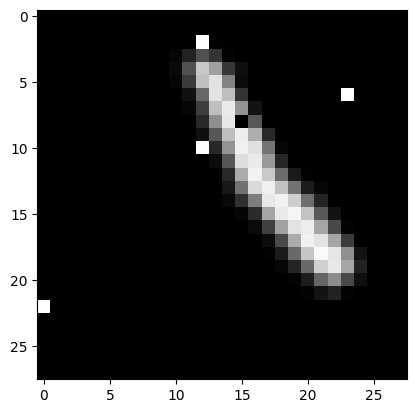

In [5]:
plt.imshow(train_images[95000], cmap= 'gray')

In [6]:
# Achatar as imagens 28x28 para uma matriz com 784 colunas (28*28 = 784)
train_images_flat = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[1])
test_images_flat = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[1])

# Normalizar os valores dos pixels para o intervalo [0, 1]
train_images_flat = train_images_flat / 255.0
test_images_flat = test_images_flat / 255.

In [7]:
class NeuralNetwork: #duvida -> será que inicio com uma array só? camada input, camada escondida e camada final tudo no mesmo?
    #classe que recebe as caracteristicas das camadas e cria os objetos
    def __init__ (self, images_train, labels_train, cam_escondida, cam_final, index_image): #cam_escondida = array que tem qnt neuronios das camadas = [10, 10] = 2 camadas com 10 neuronios
        self.index_image = index_image
        self.camada_input_valor = images_train[self.index_image] #camada de input já direta (não é tamanho, é a camada inteira mesmo)
        self.cam_escondida = cam_escondida #array com os tamanhos camadas hiddens
        self.cam_final = cam_final #tamanho da camada final
        self.cost_std = np.zeros(cam_final)
        self.cost_std[labels_train[self.index_image]] = 1
        self.number_loops = len(self.cam_escondida) # 1
        self.images_train = images_train
        self.labels_train = labels_train

    def updateImage(self, index_image):
      self.index_image = index_image
      self.camada_input_valor = self.images_train[self.index_image]
      self.cost_std = np.zeros(10)
      self.cost_std[self.labels_train[self.index_image]] = 1

    def initiateNN(self):
      self.camada_pesos = []
      self.camada_bias = []   #gera as listas das camadas (lista de vetores)
      self.camada_valores = []

      self.camada_input_pesos = np.random.randn(self.cam_escondida[0], self.camada_input_valor.shape[0]) #gera os pesos do input
      self.camada_final_valor = np.zeros((self.cam_final,1)) #gera os valores finais

      for i in range(len(self.cam_escondida)):
        if(i != len(self.cam_escondida)-1): #2 camada à penultima camada
          self.camada_pesos.append(np.random.randn(self.cam_escondida[i+1], self.cam_escondida[i]))
          self.camada_bias.append(np.zeros(self.cam_escondida[i]))
          self.camada_valores.append(np.zeros((self.cam_escondida[i],1)))

        else: #ultima camada
          self.camada_pesos.append(np.random.randn(self.cam_final, self.cam_escondida[i]))
          self.camada_bias.append(np.zeros(self.cam_escondida[i]))
          self.camada_valores.append(np.zeros((self.cam_escondida[i],1)))

    def print_camadas(self):
        # Shape do valor da camada inicial
        print(f"Input Valor: {self.camada_input_valor.shape}")
        # Shape do peso da camada inicial
        print(f"Input Peso: {self.camada_input_pesos.shape}")

        # Iterar sobre as camadas intermediárias
        for i in range(0, len(self.cam_escondida)):
            print(f"Valor Camada Escondida {i}: {self.camada_valores[i].shape}")
            print(f"Peso Camada Escondida {i}: {self.camada_pesos[i].shape}")
            print(f"Bias Camada Escondida {i}: {self.camada_bias[i].shape}")

        # Shape do valor da camada final
        print(f"Resultado Valor: {self.camada_final_valor.shape}")
        print("\n")


    def fPropagation(self):
      #print("Quantidade de Loop: ", self.number_loops)
      for i in range(self.number_loops + 1): #tem que adicionar 1, range não inclui o último indice
        #camada2_valor = sigmoid(np.dot(camada1_pesos, camada1_valor) + camada2_bias)
        #camada3_valor = sigmoid(np.dot(camada2_pesos, camada2_valor))
        if(i == 0 and i < self.number_loops):
          self.camada_valores[i] = sigmoid(np.dot(self.camada_input_pesos, self.camada_input_valor) + self.camada_bias[i])
          #print("Indice: ", i)
        elif (i != 0 and i < self.number_loops):
          self.camada_valores[i] = sigmoid(np.dot(self.camada_pesos[i-1], self.camada_valores[i-1]) + self.camada_bias[i])
          #print("Indice: ", i)
        elif (i == self.number_loops):
          self.camada_final_valor = sigmoid(np.dot(self.camada_pesos[i-1], self.camada_valores[i-1]))
          #print("Indice: ", i)
          #print("Chegou no final da Forward Propagation\n")

    def costFunc(self):
        cost = np.sum(np.power((self.camada_final_valor - self.cost_std),2))
        return cost

    #recebe o objeto atual e retorna o gradiente daquela imagem
    #o vetor gradiente está salvando as modificações da direita para esquerda: camada inicial <- camada final
    #vetor gradiente = matriz que multiplica pelo learning rate e soma no peso

    def bPropagation(self):

        gradiente_pesos = []
        gradiente_bias = []

        delta_o = self.camada_final_valor - self.cost_std

        for i in reversed(range(len(self.cam_escondida))):
          #vai pegar a ultima camada e continuar
          if i == self.number_loops-1: #se for a ultima hidden layer -> atualiza os pesos com base no delta_o
            delta_h = delta_o #* sigmoid_derivative(self.camada_final_valor)#sigmoid da camada final = 1
            #esse aqui nao calcula o bias (a camada final nao tem bias)
            #print(i, " - ", delta_h.shape)

          elif i != self.number_loops-1: #enquanto não for a ultima hidden layer e nem a primeira
            delta_h = np.dot(self.camada_pesos[i+1].T, delta_h) * sigmoid_derivative(self.camada_valores[i+1])
            gradiente_bias.insert(0,delta_h)
            #print(i, " - ", delta_h.shape)

          vetor_gradiente = np.outer(delta_h, self.camada_valores[i])
          gradiente_pesos.insert(0,vetor_gradiente)

        delta_h = np.dot(self.camada_pesos[0].T, delta_h) * sigmoid_derivative(self.camada_valores[0])
        gradiente_bias.insert(0,delta_h)
        #print(i, " - ", sigmoid_derivative(self.camada_input_valor).shape)
        vetor_gradiente = np.outer(delta_h, self.camada_input_valor)
        gradiente_pesos.insert(0,vetor_gradiente) #ja adiciona na lista e pula o resto da iteração

      # Exibir as formas dos gradientes de pesos
        # print(len(self.gradiente_pesos))
        # for i in range(len(self.gradiente_pesos)):
        #     print("Gradiente Pesos: ", self.gradiente_pesos[i].shape)
        # print(len(self.gradiente_bias))
        # for i in range(len(self.gradiente_bias)):
        #     print("Gradiente Bias: \n", self.gradiente_bias[i].shape)

        return gradiente_pesos, gradiente_bias #PRECISO DISSO PARA CALCULAR A MÉDIA DOS GRADIENTES
        #media dos gradientes é calculado no LOOP PRINCIPAL

    def updateWeights(self, learning_rate, gradiente_pesos): #recebe o gradiente médio do batch dos pesos -> atualiza o peso da rede neural com base no learning rate
      self.camada_input_pesos = self.camada_input_pesos - learning_rate * gradiente_pesos[0]
      for i in range(len(gradiente_pesos)):
        if i == 0: #se é o primeiro
          self.camada_input_pesos = self.camada_input_pesos - learning_rate * gradiente_pesos[i]
        else:
          self.camada_pesos[i-1] = self.camada_pesos[i-1] - learning_rate * gradiente_pesos[i]

    def updateBias(self, learning_rate, gradiente_bias): #recebe o gradiente médio do batch dos bias -> atualiza o bias da rede neural com base no learning rate
      #void que só atualiza os bias da rede neural, não retorna nada
      for i in range(len(self.camada_bias)):
          self.camada_bias[i] = self.camada_bias[i] - learning_rate * gradiente_bias[i]

    def embaralhar_dados(self):
      indices = np.random.permutation(self.images_train.shape[0])

      # Aplicar a permutação às imagens e labels
      self.images_train = self.images_train[indices]
      self.labels_train = self.labels_train[indices]
    
    def updateImageTest(self, test_images, index_image):
      self.camada_input_valor = test_images[index_image]

    def updateImageCustom(self, test_image):
        test_image = Image.open(test_image).convert('L')  # 'L' é para grayscale (escala de cinza)
        test_image = np.array(test_image)

        tamanho_image = self.camada_input_valor.shape[0]
        tamanho_image = int(math.sqrt(tamanho_image))
        
        # Verifica se a imagem tem as dimensões corretas (28x28)
        assert test_image.shape == (tamanho_image, tamanho_image), "A imagem deve ter a quantidade de pixels correta."

        # Achata a imagem para ser um vetor de 28*28
        test_image = test_image.reshape(tamanho_image*tamanho_image)
        test_image = test_image/255.0
        
        self.camada_input_valor = test_image

    def updateImageCustomDraw(self, test_image):
        # Certifique-se que test_image é um numpy array
        if isinstance(test_image, np.ndarray):
            # Verifica se a imagem tem as dimensões corretas (28x28)
            assert test_image.shape == (28, 28), "A imagem deve ter a quantidade de pixels correta."
        else:
            raise ValueError("test_image deve ser um array numpy.")

        # Achata a imagem para ser um vetor de 28*28
        test_image = test_image.reshape(28 * 28)
        test_image = test_image / 255.0

        self.camada_input_valor = test_image

    def testeModelo(self, test_images, test_labels):

      qnt_certos = 0

      for i in range(len(test_images)):
        self.updateImageTest(test_images, i)
        self.fPropagation()
        indice_max = np.argmax(self.camada_final_valor)
        if indice_max == test_labels[i]:
          qnt_certos += 1

      return qnt_certos/len(test_images) * 100


    def preverImagem(self, test_images, test_labels, index):
      self.updateImageTest(test_images, index)
      self.fPropagation()
      indice_max = np.argmax(self.camada_final_valor)

      if(indice_max == test_labels[index]):
        print("Correto: ", "\nPrevisto: ",labels[indice_max], " - Certeza: ", self.camada_final_valor[indice_max] * 100, "%", "\nEsperado: ", labels[test_labels[index]])
      else:
        print("Incorreto: ", "\nPrevisto: ",labels[indice_max], " - Certeza: ", self.camada_final_valor[indice_max] * 100, "%", "\nEsperado: ", labels[test_labels[index]])

      tamanho_image = self.camada_input_valor.shape[0]
      tamanho_image = int(math.sqrt(tamanho_image))
      img_reshaped = test_images[index].reshape(tamanho_image, tamanho_image)

      # Exibe a imagem utilizando o matplotlib
      plt.imshow(img_reshaped, cmap='gray')
      plt.show()

    def copy(self):
      # Faz uma cópia profunda do objeto atual
        copia_rede = NeuralNetwork(
            self.images_train,
            self.labels_train,
            copy.deepcopy(self.cam_escondida),
            copy.deepcopy(self.cam_final),
            self.index_image
        )
        # Copia todos os atributos necessários
        copia_rede.camada_input_valor = copy.deepcopy(self.camada_input_valor)
        copia_rede.camada_pesos = copy.deepcopy(self.camada_pesos)
        copia_rede.camada_bias = copy.deepcopy(self.camada_bias)
        copia_rede.camada_valores = copy.deepcopy(self.camada_valores)
        copia_rede.camada_input_pesos = copy.deepcopy(self.camada_input_pesos)
        copia_rede.camada_final_valor = copy.deepcopy(self.camada_final_valor)
        copia_rede.cost_std = copy.deepcopy(self.cost_std)

        return copia_rede

    def verCamadaHidden(self):
      tamanho_image = self.camada_input_valor.shape[0]
      tamanho_image = int(math.sqrt(tamanho_image))
      for i in range(self.camada_input_pesos.shape[0]):
        aux_image = self.camada_input_pesos[i].reshape(tamanho_image, tamanho_image)

        # Exibe a imagem utilizando o matplotlib
        plt.imshow(aux_image, cmap='gray')
        plt.show()

    def preverImagemCustom(self,customImage):
      self.updateImageCustom(customImage)
      self.fPropagation()
      indice_max = np.argmax(self.camada_final_valor)

      print("Previsto: ", labels[indice_max], " - Certeza: ", self.camada_final_valor[indice_max] * 100,"%")

      # Exibe a imagem utilizando o matplotlib
      tamanho_image = self.camada_input_valor.shape[0]
      tamanho_image = int(math.sqrt(tamanho_image))
      img_reshaped = self.camada_input_valor.reshape(tamanho_image, tamanho_image)
      plt.imshow(img_reshaped, cmap='gray')
      plt.show()

    def preverImageCustomOnlyText(self, customImage):
      self.updateImageCustomDraw(customImage)
      self.fPropagation()
      indice_max = np.argmax(self.camada_final_valor)

      return labels[indice_max], self.camada_final_valor[indice_max]*100


In [8]:
def soma_gradiente(pesoMedio, biasMedio, pesoNovo, biasNovo):
  pesoMedioAtualizado = []
  biasMedioAtualizado = []

  for i in range(len(pesoMedio)):
    auxMedio = np.array(pesoMedio[i])
    auxNovo = np.array(pesoNovo[i])
    auxresult = auxMedio + auxNovo
    pesoMedioAtualizado.append(auxresult)
  for i in range(len(biasMedio)):
    auxMedio = np.array(biasMedio[i])
    auxNovo = np.array(biasNovo[i])
    auxresult = auxMedio + auxNovo
    biasMedioAtualizado.append(auxresult)

  return pesoMedioAtualizado, biasMedioAtualizado


In [9]:
def media_gradiente(gradientePeso, gradienteBias, batch_size):
  mediaGradientePeso = []
  mediaGradienteBias = []

  for i in range(len(gradientePeso)):
    auxMedio = np.array(gradientePeso[i])
    auxresult = auxMedio/batch_size
    mediaGradientePeso.append(auxresult)

  for i in range(len(gradienteBias)):
    auxMedio = np.array(gradienteBias[i])
    auxresult = auxMedio/batch_size
    mediaGradienteBias.append(auxresult)

  return mediaGradientePeso, mediaGradienteBias

In [10]:
def treinarRede(redeNeural, learning_rate, batch_size, epocas, test_images, test_labels):
    # Inicializando a rede neural
    lista_precisao = []
    lista_custo = []
    melhor_modelo = 0
    redeNeural.initiateNN()
    imagemPadrao = redeNeural.camada_input_valor
    redeNeural.fPropagation()
    lista_custo.append(redeNeural.costFunc())
    print("Custo Inicial: ",redeNeural.costFunc())

    for i in range(epocas): # Quantidade de épocas

        redeNeural.embaralhar_dados()
        redeNeural.updateImage(0)
        redeNeural.fPropagation()

        if i == 0:
          lista_precisao.append(redeNeural.testeModelo(test_images, test_labels))

        aux_index = 0  # Reinicia o índice auxiliar para cada época

        for k in range(len(redeNeural.images_train) // batch_size):
            # Inicializa os gradientes com o primeiro exemplo do batch
            redeNeural.updateImage(aux_index)
            pesoMedio, biasMedio = redeNeural.bPropagation()  # -> lista de ndarray

            for j in range(1, batch_size):  # Para o restante do batch
                redeNeural.updateImage(j + aux_index)
                redeNeural.fPropagation()
                pesoNovo, biasNovo = redeNeural.bPropagation()
                pesoMedio, biasMedio = soma_gradiente(pesoMedio, biasMedio, pesoNovo, biasNovo)  # Soma gradientes

            # Calcula o gradiente médio para o batch
            gradientePeso, gradienteBias = media_gradiente(pesoMedio, biasMedio, batch_size)
            redeNeural.updateWeights(learning_rate, gradientePeso)  # Atualiza pesos
            redeNeural.updateBias(learning_rate, gradienteBias)  # Atualiza bias
            redeNeural.fPropagation()

            aux_index += batch_size  # Atualiza o índice para o próximo batch

        redeNeural.camada_input_valor = imagemPadrao
        redeNeural.fPropagation()
        lista_custo.append(redeNeural.costFunc())

        # Realiza propagação após a atualização dos pesos e bias
        print(f'Época {i + 1}/{epocas}, Custo: {lista_custo[i+1]}')
        lista_precisao.append(redeNeural.testeModelo(test_images, test_labels))
        print(f'Época {i + 1}/{epocas}, Precisão: {lista_precisao[i+1]}')

        if(lista_precisao[i+1] > melhor_modelo):
          melhor_modelo = lista_precisao[i+1]
          modelo_temp = redeNeural.copy()

    return lista_custo, lista_precisao, modelo_temp

In [11]:
def saveModelo(modelo):
    filename = f'{modelo.__class__.__name__}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(modelo, file)

def loadModelo(nome):
    with open(nome, 'rb') as file:
        modelo = pickle.load(file)
        return modelo

In [12]:
rede1 = NeuralNetwork(train_images_flat, train_labels,[32,32],10,0)
lista_custo, lista_precisao, melhor_modelo = treinarRede(rede1,0.4, 16, 50, test_images_flat, test_labels)

Custo Inicial:  3.380067484811261


KeyboardInterrupt: 

In [ ]:
for i in range(30,35):
  melhor_modelo.preverImagem(test_images_flat, test_labels, i)

saveModelo(melhor_modelo)

NameError: name 'melhor_modelo' is not defined

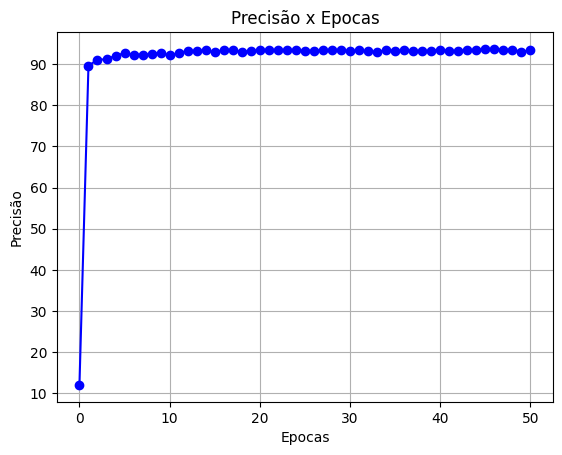

In [ ]:
indices = list(range(len(lista_precisao)))

# Criando o gráfico
plt.plot(indices, lista_precisao, marker='o', linestyle='-', color='b')

# Adicionando título e rótulos
plt.title('Precisão x Epocas')
plt.xlabel('Epocas')
plt.ylabel('Precisão')

# Mostrando a grade
plt.grid()

# Exibindo o gráfico
plt.show()

In [13]:
#print(melhor_modelo.testeModelo(test_images_flat, test_labels))
#melhor_modelo.verCamadaHidden()

modelo = loadModelo('323210.pkl')
print(modelo.testeModelo(test_images_flat, test_labels))

93.7


In [14]:
import pygame
from PIL import Image
import numpy as np
import time

def main(modelo):
    window_size = 280
    scale = 15
    pixel_size = 28

    pygame.init()
    screen = pygame.display.set_mode((window_size, window_size))
    pygame.display.set_caption("Desenhe o Número")
    font = pygame.font.Font(None, 16)
    
    background_color = (0, 0, 0)
    draw_color = (255, 255, 255)
    screen.fill(background_color)
    drawing = False
    last_inference_time = time.time()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                drawing = True
            elif event.type == pygame.MOUSEBUTTONUP:
                drawing = False
            elif event.type == pygame.MOUSEMOTION and drawing:
                x, y = event.pos
                pygame.draw.rect(screen, draw_color, (x, y, scale, scale))
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    screen.fill(background_color)
                    pygame.display.flip()

        pygame.display.flip()

        current_time = time.time()
        if current_time - last_inference_time > 1:
            last_inference_time = current_time
            
            try:
                # Processamento da imagem para inferência
                pygame_image = pygame.surfarray.array3d(pygame.display.get_surface()).swapaxes(0, 1)
                img = Image.fromarray(pygame_image).convert('L').resize((pixel_size, pixel_size), Image.LANCZOS)

                # Converte a imagem em um array NumPy
                img_array = np.array(img)

                # Usar a função de previsão com a imagem processada
                numero, certeza = modelo.preverImageCustomOnlyText(img_array)

                # Exibir o número e a certeza na janela
                screen.fill(background_color, (0, 0, window_size, 50))
                texto = font.render(f"Número: {numero}, Certeza: {certeza:.2f}%", True, draw_color)
                screen.blit(texto, (10, 10))

            except Exception as e:
                print(f"Erro ao processar a imagem: {e}")

    pygame.quit()

if __name__ == "__main__":
    main(modelo)
